In [109]:
# data collection from repository from bitbucket

!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [110]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [111]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
import pickle
import pandas as pd
import random

In [112]:
np.random.seed(0)

In [113]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f) 
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f) 
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f) 

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [114]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [115]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the numbe rof labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the numbe rof labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the numbe rof labels"

assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32x32x3"

In [116]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

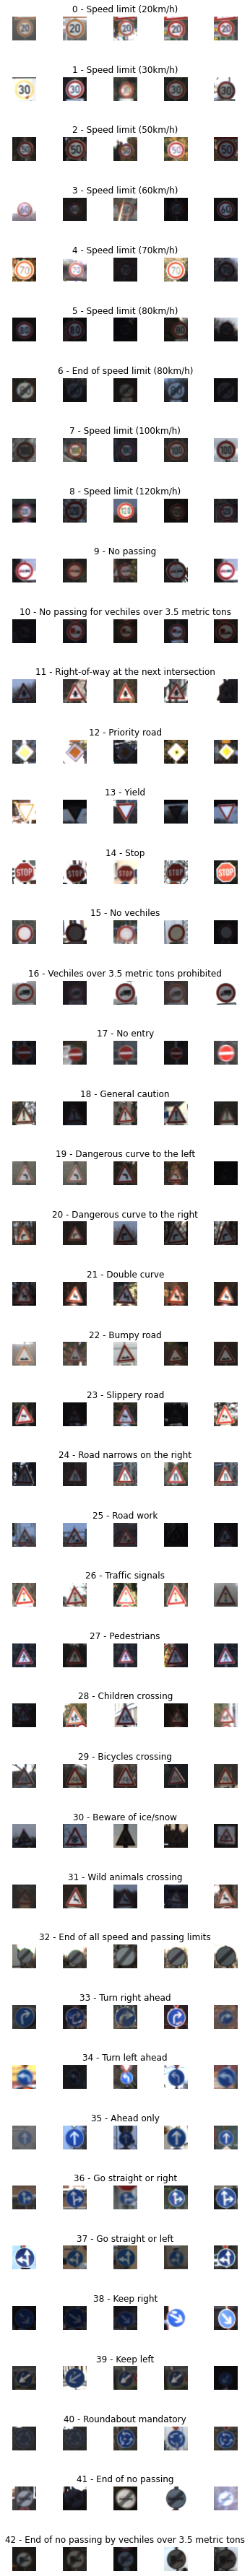

In [117]:
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + " - " + row["SignName"])
        num_of_samples.append(len(x_selected))


    

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


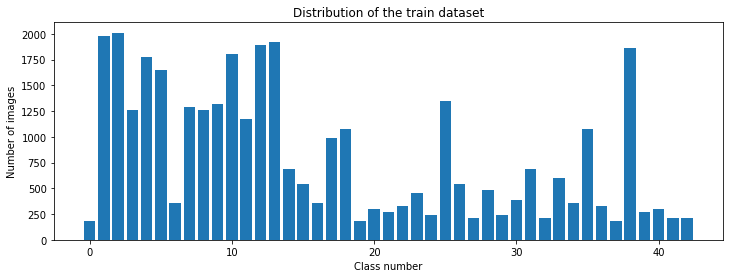

In [118]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


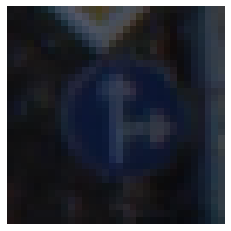

In [119]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


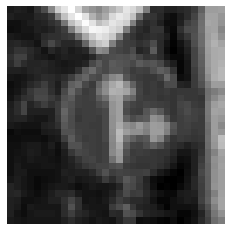

In [120]:
def grayscale(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

(32, 32)


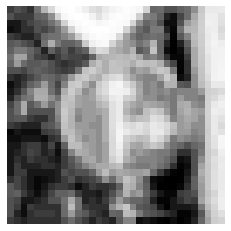

In [121]:
# histogram equaliztion --> to equalize the lighting

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

img = equalize(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.axis("off")
print(img.shape)

In [122]:
# cinverts to grayscale and normalizing light intensity
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


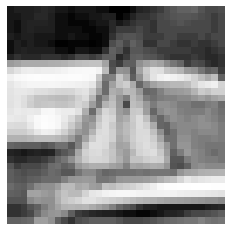

In [123]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)], cmap = plt.get_cmap('gray'))
plt.axis("off")
print(X_train.shape)

In [124]:
# adding depth to these images

X_train = X_train.reshape(34799, 32, 32, 1) 
X_test = X_test.reshape(12630, 32, 32, 1) 
X_val = X_val.reshape(4410, 32, 32, 1) 

In [125]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [126]:
# one-hot encoding

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [127]:
# designing the neural network.

def modified_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5), input_shape = (32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(30, (3,3),activation='relu'))
  model.add(Conv2D(30, (3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  #compile model
  model.compile(Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics = ['accuracy'])
  return model

In [128]:
model = modified_model()
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 60)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_23 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 4, 4, 30)         0         
 g2D)                                                 

In [129]:
history = model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val), batch_size = 400, verbose = 1, shuffle = 1)

Epoch 1/10
87/87 [==============================] - 4s 35ms/step - loss: 2.4048 - accuracy: 0.3493 - val_loss: 0.6641 - val_accuracy: 0.8200
Epoch 2/10
87/87 [==============================] - 3s 32ms/step - loss: 0.6591 - accuracy: 0.7952 - val_loss: 0.2916 - val_accuracy: 0.9206
Epoch 3/10
87/87 [==============================] - 3s 32ms/step - loss: 0.3759 - accuracy: 0.8841 - val_loss: 0.1831 - val_accuracy: 0.9449
Epoch 4/10
87/87 [==============================] - 3s 34ms/step - loss: 0.2783 - accuracy: 0.9129 - val_loss: 0.1461 - val_accuracy: 0.9560
Epoch 5/10
87/87 [==============================] - 3s 33ms/step - loss: 0.2101 - accuracy: 0.9336 - val_loss: 0.1057 - val_accuracy: 0.9689
Epoch 6/10
87/87 [==============================] - 3s 33ms/step - loss: 0.1757 - accuracy: 0.9452 - val_loss: 0.0811 - val_accuracy: 0.9751
Epoch 7/10
87/87 [==============================] - 3s 33ms/step - loss: 0.1515 - accuracy: 0.9540 - val_loss: 0.0882 - val_accuracy: 0.9744
Epoch 8/10
87

Text(0.5, 0, 'epoch')

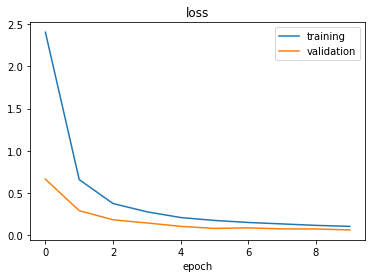

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

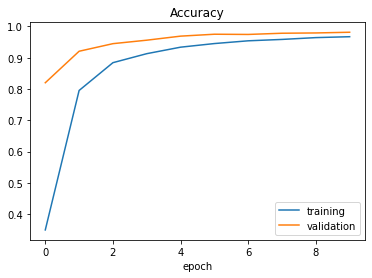

In [131]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [132]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])


Test Score: 0.13088922202587128
Test Accuracy: 0.9612826704978943


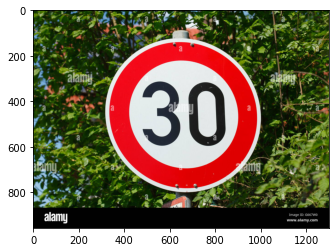

In [133]:
# real data testing

#fetch image
 
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


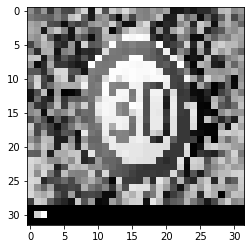

In [134]:
#Preprocess image
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [135]:
#Reshape reshape
img = img.reshape(1, 32, 32, 1)

In [138]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img), axis=-1)))

1/1 [==============================] - 1s 935ms/step
predicted sign: [1]
